In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Reading

In [5]:
orders_df = pd.DataFrame()
for i in range(1,6):
    path = f'../data/raw/tabla_ordenes_{str(i)}.xlsx'
    orders = pd.read_excel(path)
    orders_df = orders_df._append(orders, ignore_index=True)
    
products_df = pd.read_excel('../data/raw/tabla_producto.xlsx')
departments_df = pd.read_excel('../data/raw/tabla_departamento.xlsx')
aisles_df = pd.read_excel('../data/raw/tabla_pasillos.xlsx')

# Basic Data Overview

In [6]:
print(orders_df.shape)
orders_df.head()

(1384615, 5)


,id_linea,id_orden,id_producto,incluido_orden_carrito,reordenado
0,0,1,49302,1,1
1,1,1,11109,2,1
2,2,1,10246,3,0
3,3,1,49683,4,0
4,4,1,43633,5,1


In [7]:
print(products_df.shape)
products_df.head()

(49338, 4)


,id_producto,nombre_producto,id_pasillo,id_departamento
0,1,GALLETAS DEL EMPAREDADO DEL CHOCOLATE,61,19
1,2,TODAS ESTACIONES DE SALT,104,13
2,3,ROBUSTA DE ORO SIN AZÚCAR TÉ OOLONG,94,7
3,4,SALSA INTELIGENTES ONES FAVORITOS MINI CLÁSICO...,38,1
4,5,EN CUALQUIER MOMENTO SALSA VERDE CHILE,5,13


In [8]:
print(departments_df.shape)
departments_df.head()

(21, 2)


,id_departamento,departamento
0,1,CONGELADOS
1,2,OTROS
2,3,PANADERÍA
3,4,FRUTAS Y VERDURAS
4,5,BEBIDAS ALCOHOLICAS


In [9]:
print(aisles_df.shape)
aisles_df.head()

(134, 2)


,id_pasillo,pasillo
0,1,SOPAS PREPARADAS ENSALADAS
1,2,QUESOS DE ESPECIALIDAD
2,3,BARRAS DE GRANOLA DE ENERGÍA
3,4,ALIMENTOS INSTANTÁNEOS
4,5,PREPARACIÓN DE LA CARNE MARINADOS


In [10]:
# Missing values and data types
for df in [orders_df, products_df, departments_df, aisles_df]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384615 entries, 0 to 1384614
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype
---  ------                  --------------    -----
 0   id_linea                1384615 non-null  int64
 1   id_orden                1384615 non-null  int64
 2   id_producto             1384615 non-null  int64
 3   incluido_orden_carrito  1384615 non-null  int64
 4   reordenado              1384615 non-null  int64
dtypes: int64(5)
memory usage: 52.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49338 entries, 0 to 49337
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id_producto      49338 non-null  int64 
 1   nombre_producto  49338 non-null  object
 2   id_pasillo       49338 non-null  int64 
 3   id_departamento  49338 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Ra

In [11]:
# Duplicates
print(f'{orders_df["id_linea"].nunique()} vs {orders_df.shape[0]}')
print(f'{products_df["id_producto"].nunique()} vs {products_df.shape[0]}')
print(f'{departments_df["id_departamento"].nunique()} vs {departments_df.shape[0]}')
print(f'{aisles_df["id_pasillo"].nunique()} vs {aisles_df.shape[0]}')

1384615 vs 1384615
49338 vs 49338
21 vs 21
134 vs 134


# Joins Validation

In [12]:
# First step is to join products with department and aisle
products_df2 = products_df\
    .merge(departments_df,
           on= 'id_departamento',
           how= 'left')\
    .merge(aisles_df,
           on= 'id_pasillo',
           how='left')

# Check for non-matching products
products_df2.isna().sum()

id_producto        0
nombre_producto    0
id_pasillo         0
id_departamento    0
departamento       0
pasillo            0
dtype: int64

In [13]:
# The next step is to join the orders with the products including department and aisle information
df = orders_df.merge(products_df2,
                     on= 'id_producto',
                     how= 'left')

# Check for non-matching products
df.isna().sum()

id_linea                      0
id_orden                      0
id_producto                   0
incluido_orden_carrito        0
reordenado                    0
nombre_producto           14916
id_pasillo                14916
id_departamento           14916
departamento              14916
pasillo                   14916
dtype: int64

In [14]:
# Count how many products are in orders but not in the product catalogue
missing_products_count = df[(df['nombre_producto'].isna())]['id_producto'].nunique()
print(f'There is a total of {missing_products_count} products missing in catalogue')

# Impact on the whole dataset
df.isna().sum() / df.shape[0]

There is a total of 275 products missing in catalogue


id_linea                  0.000000
id_orden                  0.000000
id_producto               0.000000
incluido_orden_carrito    0.000000
reordenado                0.000000
nombre_producto           0.010773
id_pasillo                0.010773
id_departamento           0.010773
departamento              0.010773
pasillo                   0.010773
dtype: float64

# Descriptive Statistics

In [15]:
df.dtypes

id_linea                    int64
id_orden                    int64
id_producto                 int64
incluido_orden_carrito      int64
reordenado                  int64
nombre_producto            object
id_pasillo                float64
id_departamento           float64
departamento               object
pasillo                    object
dtype: object

In [17]:
# Reordered feature seems to be categorical
df['reordenado'].value_counts()

reordenado
1    828822
0    555793
Name: count, dtype: int64

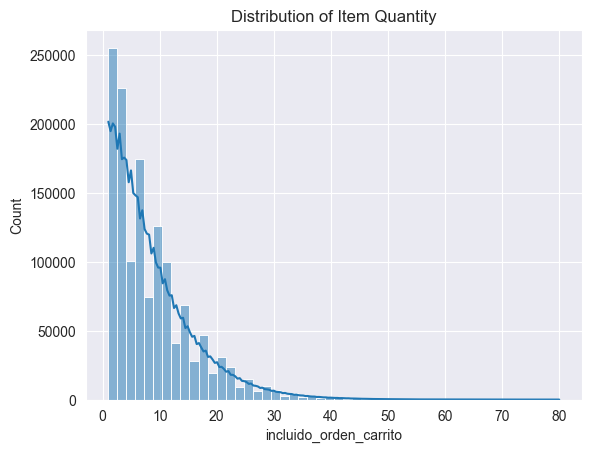

In [18]:
# Products quantity distribution
# Plot the distribution of quantity
sns.histplot(df['incluido_orden_carrito'], bins=50, kde=True)
plt.title('Distribution of Item Quantity')
plt.show()

Average number of items per shopping cart: 10.55274409529834
Average number of distinct products per shopping cart: 10.55274409529834


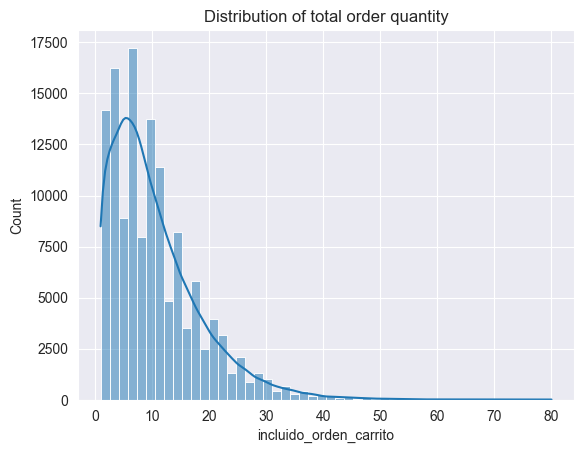

In [25]:
# Total orders quantity distribution
orders_group_df = df.groupby(['id_orden'],
                             as_index=False).agg({'incluido_orden_carrito':'max',
                                                  'id_producto':'nunique'})

avg_items = orders_group_df['incluido_orden_carrito'].mean()
avg_distinct_products = orders_group_df['id_producto'].mean()
print(f'Average number of items per shopping cart: {avg_items}')
print(f'Average number of distinct products per shopping cart: {avg_distinct_products}')

# Plot the distribution of quantity
sns.histplot(orders_group_df['incluido_orden_carrito'], bins=50, kde=True)
plt.title('Distribution of total order quantity')
plt.show()

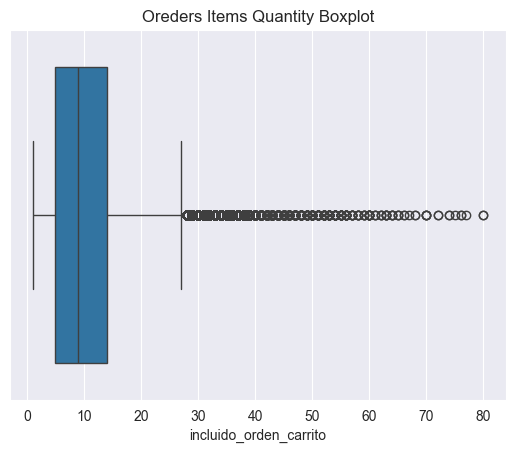

In [27]:
# Outliers detection

# Plotting the boxplots
sns.boxplot(x=orders_group_df['incluido_orden_carrito'])
plt.title('Oreders Items Quantity Boxplot')
plt.show()

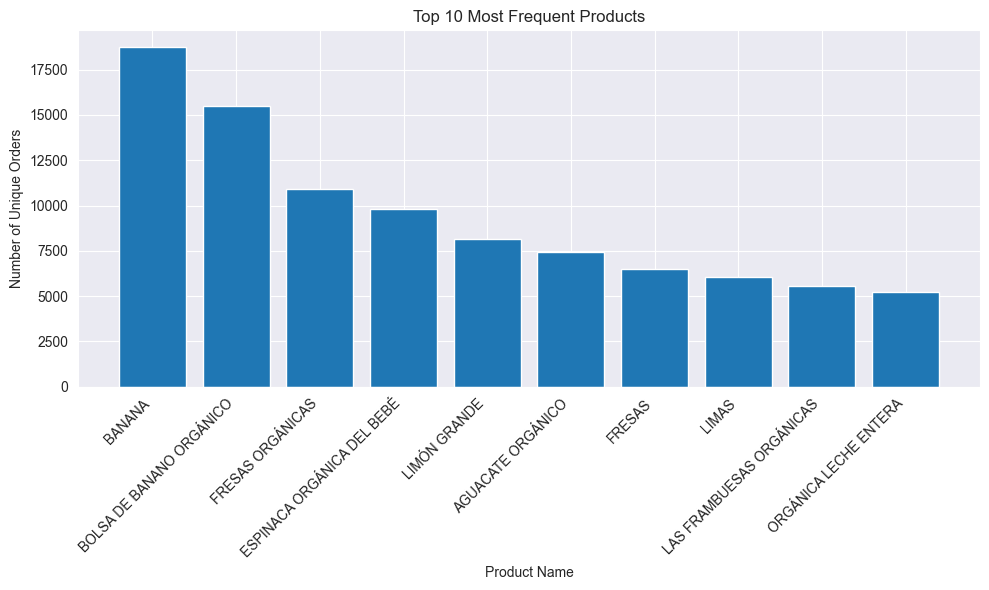

In [28]:
# Most frequent and higher volume products
df_products_grouped = df.groupby(['nombre_producto'],
                                 as_index=False).agg({'id_orden':'nunique'})

# Get the top 10
top_10_products_frequency = df_products_grouped\
    .sort_values(by='id_orden', ascending=False)\
    .head(10)

# Plot
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.bar(top_10_products_frequency['nombre_producto'], top_10_products_frequency['id_orden'], align='center')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Unique Orders')
plt.xticks(rotation=45, ha='right')  # Rotate x labels and align them to the right for better readability
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()

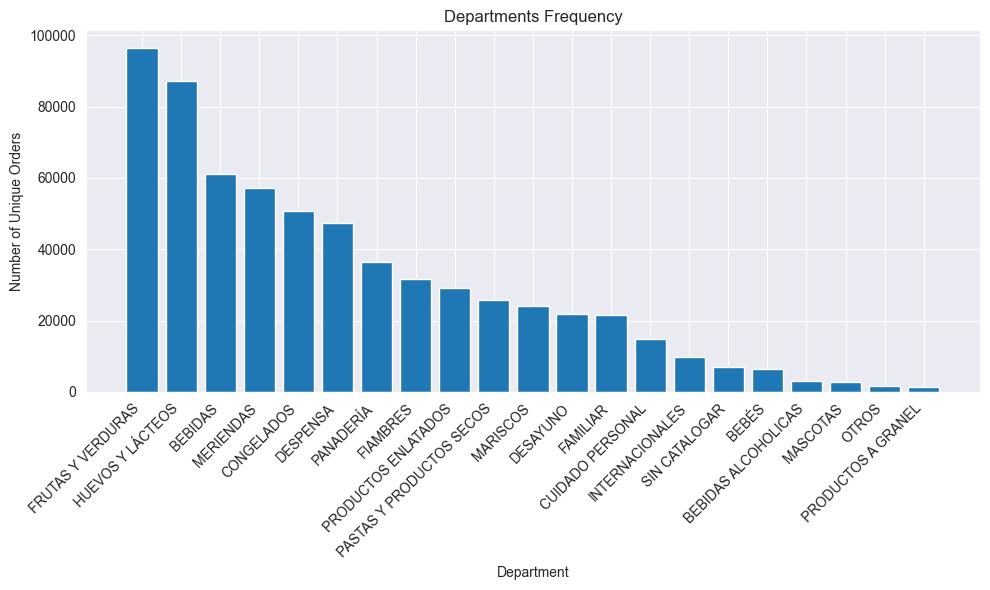

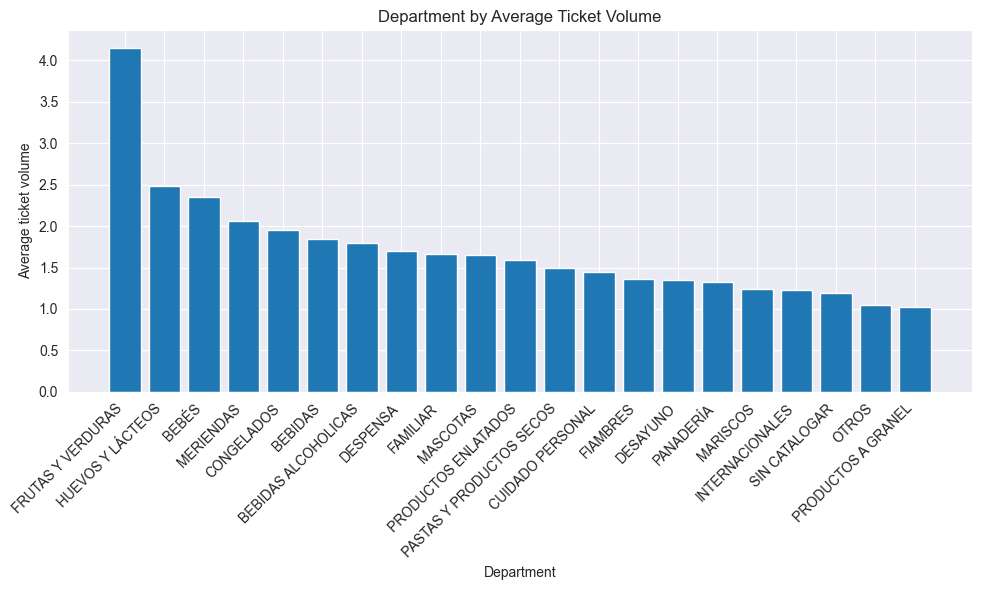

In [30]:
# Most frequent and higher volume departments
df_orders_departments_grouped = df.groupby(['id_orden','departamento'],
                                           as_index=False).agg({'id_producto':'nunique'})

df_departments_grouped = df_orders_departments_grouped\
    .groupby(['departamento'],
             as_index=False).\
    agg({'id_orden':'nunique',
         'id_producto':'mean'})

df_departments_grouped.sort_values(by='id_orden',ascending=False,inplace=True)

# Plot
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.bar(df_departments_grouped['departamento'], 
        df_departments_grouped['id_orden'], 
        align='center')
plt.title('Departments Frequency')
plt.xlabel('Department')
plt.ylabel('Number of Unique Orders')
plt.xticks(rotation=45, ha='right')  # Rotate x labels and align them to the right for better readability
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()

df_departments_grouped.sort_values(by='id_producto',ascending=False,inplace=True)

plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.bar(df_departments_grouped['departamento'], 
        df_departments_grouped['id_producto'], 
        align='center')
plt.title('Department by Average Ticket Volume')
plt.xlabel('Department')
plt.ylabel('Average ticket volume')
plt.xticks(rotation=45, ha='right')  # Rotate x labels and align them to the right for better readability
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()